# 動的最適化

In [1]:
import numpy as np
import sys
import math
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *
from functools import lru_cache
sys.setrecursionlimit(10000)
%matplotlib inline

## 確定的動的最適化の例

### 再帰とメモ化

##### Fibonacci数
以下のように再帰的に定義される．  
$F_n = F_{n-1} + F_{n-2},$  
$F_1 = F_2 = 1$

In [2]:
def fibonacci(n):
    if n == 1 or n == 2:
        return 1
    else:
        return fibonacci(n-2) + fibonacci(n-1)

これは何回も同じ関数が呼ばれ，効率が悪い  
-> 引数としてmemoと名付けた辞書を渡し，一度計算した関数は記憶するようにする

In [8]:
def fibonacci_memo(n, memo={}):
    if n == 1 or n == 2:
        return 1
    elif n not in memo:
        memo[n] = fibonacci_memo(n-1) + fibonacci_memo(n-2)
    return memo[n]

In [20]:
fibonacci_memo(100)

354224848179261915075

デコレ―タ関数lru_cacheを用いるとさらに簡潔に書ける（lruはleast recently usedの略）

In [16]:
@lru_cache(maxsize=None)
def fibonacci_memo2(n):
    if n == 1 or n == 2:
        return 1
    else:
        return fibonacci_memo2(n-1) + fibonacci_memo2(n-2)

In [21]:
fibonacci_memo2(100)

354224848179261915075

### ナップサック問題

In [75]:
def create_toy_problem(size, seed):
    np.random.seed(seed)
    s = np.random.randint(2, 10, size=size)
    v = s + np.random.randint(-1, 3, size=size)
    return s, v

#### 整数ナップサック問題

Pulpから解く

In [10]:
s, v = create_toy_problem(size=100, seed=7)
b = 20
n = len(v)

prob = LpProblem(sense=LpMaximize)
x = [LpVariable(f'x{i}', lowBound=0, cat='Integer') for i in range(n)]
prob += lpSum(v[i] * x[i] for i in range(n))
prob += lpSum(s[i] * x[i] for i in range(n)) <= b

prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')

Status:  Optimal
Optimal value = 40.0


動的解法

In [76]:
def knapsack_problem(b):
    if b == 0:
        return 0
    if b < 0:
        return -99999
    max_value = 0
    for i, size in enumerate(s):
        max_value = max(max_value, knapsack_problem(b-size) + v[i])
    return max_value

In [81]:
s, v = create_toy_problem(size=20, seed=7)
knapsack_problem(b=10)

20

メモ化を用いた解法

In [57]:
def knapsack_problem_memo(b, memo={}):
    if b == 0:
        return 0
    if b < 0:
        return -99999
    if b in memo:
        return memo[b]
    else:
        max_value = 0
        for i in range(len(s)):
            max_value = max(max_value, knapsack_problem_memo(b-s[i]) + v[i])
        memo[b] = max_value
        return max_value

In [65]:
s, v = create_toy_problem(size=100, seed=7)
knapsack_problem_memo(300)

585

再帰を用いない前進型の動的最適化アルゴリズム

In [5]:
s, v = create_toy_problem(size=20, seed=7)
b = 10

# 各thetaに対して1つアイテムを足した時の値を見る
# 解が良くなるなら更新．結局すべてのthetaに対して最も良い解を求めている
f = {theta: 0 for theta in range(b+1)}
for theta in range(b-min(s)+1):
    for i, size in enumerate(s):
        if theta + size > b:
            continue
        if f[theta+size] < f[theta] + v[i]:
            f[theta+size] = f[theta] + v[i]

print('Optimal value: ', f[b])

Optimal value:  20


#### 0-1ナップサック問題

In [11]:
s, v = create_toy_problem(size=100, seed=7)
b = 20
n = len(v)

prob = LpProblem(sense=LpMaximize)
x = [LpVariable(f'x{i}', lowBound=0, cat='Binary') for i in range(n)]
prob += lpSum(v[i] * x[i] for i in range(n))
prob += lpSum(s[i] * x[i] for i in range(n)) <= b

prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')

Status:  Optimal
Optimal value = 38.0


In [127]:
def knapsack_problem_01(k, b, memo={}):
    if b < 0:
        return -99999
    if k == 0:
        if b >= s[0]:
            return v[0]
        else:
            return 0
    if (k, b) in memo:
        return memo[k, b]
    else:
        max_value = max(knapsack_problem_01(k-1, b), knapsack_problem_01(k-1, b-s[k]) + v[k])
        memo[k, b] = max_value
        return max_value

In [128]:
s, v = create_toy_problem(size=100, seed=7)
b = 20
k = len(v) - 1
knapsack_problem_01(k, b)

38

### 最大安定集合問題

In [76]:
class Create_toy_problem2:
    def __init__(self, size, seed):
        self.size = size
        self.seed = seed

    def ex1(self):
        np.random.seed(self.seed)
        w = np.random.randint(1, 5, size=self.size)
        return w
    
    def ex2(self):
        np.random.seed(self.seed)
        w = np.random.randint(1, 5, size=self.size)
        while True:
            G = nx.fast_gnp_random_graph(n=self.size, p=0.3, seed=self.seed)
            if nx.is_connected(G):
                break
        return G, w

グラフが一列に並んでいる特殊な状況を考える

In [77]:
def path_stable(i, memo={}):
    if i < 0:
        return 0
    elif i == 0:
        return w[i]
    elif i not in memo:
        max_value = max(path_stable(i-1), path_stable(i-2)+w[i])
        memo[i] = max_value
    return memo[i]

In [78]:
w = Create_toy_problem2(size=20, seed=7).ex1()
n = len(w)
print(path_stable(n-1))

31


前進型

In [79]:
w = Create_toy_problem2(size=20, seed=7).ex1()
n = len(w)
f = {-1: 0, 0: w[0]}
for i in range(1, n):
    f[i] = max(f[i-1], f[i-2]+w[i])
print('Optimal value: ', f[n-1])

Optimal value:  31


最適解

In [82]:
i = n-1
opt_sol = []

# i番目が最適解に含まれるか判定
while i >= 1:
    if f[i-1] >= f[i-2] + w[i]:  # 含まれない
        i = i-1
    else:  # 含まれる
        opt_sol.append(i)
        i = i-2
if np.min(opt_sol) != 1:
    opt_sol.append(0)
print('Optimal solution: ', opt_sol)

Optimal solution:  [18, 16, 14, 11, 9, 7, 5, 3, 0]


In [83]:
np.sum(w[opt_sol])

31

一般のグラフに対して最大安定集合問題を考える

In [162]:
def stable(S, memo={}):
    if len(S) == 0:
        return 0
    if len(S) == 1:
        return w[S.pop()]
    fs = frozenset(S)
    if fs in memo:
        return memo[fs]
    else:
        max_value = 0
        for i in range(len(S)):
            S0 = S[:]
            k = S0.pop(i)
            S1 = set(S0).difference(set(G.adj[k].keys()))  # G.adj[k]: kに隣接する点をキーにもつ辞書を返す
            max_value = max(stable(S0), stable(list(S1))+w[k], max_value)
        memo[fs] = max_value
        return max_value

Optimal value:  13


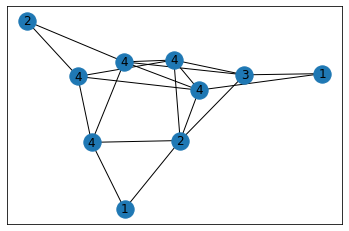

In [163]:
G, w = Create_toy_problem2(10, 7).ex2()
pos = nx.spring_layout(G)
weight = {i: w[i] for i in range(len(G.nodes()))}
nx.draw_networkx(G, pos=pos, with_labels=True, labels=weight)

print('Optimal value: ', stable(list(G.nodes())))

### 巡回セールスマン問題

In [5]:
def toy_problem3(n_nodes, seed):
    np.random.seed(seed)
    x = np.random.randint(low=0, high=1000, size=n_nodes)
    y = np.random.randint(low=0, high=1000, size=n_nodes)
    p = {i: (x[i], y[i]) for i in range(n)}
    D = np.sqrt((x.reshape(-1, 1) - x)**2 + (y.reshape(-1, 1) - y)**2)
    return n_nodes, D, G, p

In [6]:
def TSP(j, S, memo={}):
    fs = frozenset(S)
    if (j, fs) in memo:
        return memo[j, fs]
    elif fs == frozenset({j}):
        return d[n-1, j]  # n-1を始点とするため（別にどこでもいい）
    else:
        S0 = S.copy()
        S0.remove(j)
        min_value = 99999
        for i in S0:
            min_value = min(TSP(i, S0, memo)+d[i, j], min_value)
        memo[j, fs] = min_value
        return min_value

In [7]:
n, d, G, p = toy_problem3(15, 7)

NameError: name 'n' is not defined

In [158]:
TSP(n-1, set(range(n)))

3212.9000112123576

### 集合被覆問題

In [61]:
def toy_problem4(m, n, seed):
    np.random.seed(seed)
    a = np.random.randint(0, 2, size=(m, n))
    # どの施設にもカバーされない需要があれば作り直し
    while np.all(a.sum(axis=1) == 0):
        seed += 1
        np.random.seed(seed)
        a = np.random.randint(0, 2, size=(m, n))
    S = {}  # j番目の列で1が入っているインデックスの番号を格納した辞書
    for j in range(n):
        S[j] = [i for i in range(m) if a[i, j] == 1]
    return m, n, a, S

In [65]:
def set_cover(k, C, memo={}):
    if len(C) == 0:
        return 0
    if k < 0:
        return 99999
    fs = frozenset(C)
    if (k, fs) in memo:
        return memo[k, fs]
    C0 = C.copy()
    C1 = C0.difference(S[k])
    min_value = min(set_cover(k-1, C0), set_cover(k-1, C1)+1)
    memo[k, fs] = min_value
    return memo[k, fs]

In [72]:
m, n, a, S = toy_problem4(m=50, n=10, seed=7)

In [73]:
set_cover(n-1, set(range(m)))

4

## 確率的動的最適化

レンタカー営業所の問題

In [2]:
max_car = 10  # 各営業所での保管台数の最大値
n_car_dim = max_car + 1  # 各営業所での保管台数のあり得る場合の数
max_move = 5  # 移動できる最大台数
lam_1_r, lam_1_h, lam_2_r, lam_2_h = 3, 3, 4, 2  # 貸出数と返却数を制御するPoisson分布のパラメータ
V = np.zeros((n_car_dim, n_car_dim))  # 各状態での効用の期待値
pi = np.zeros((n_car_dim, n_car_dim), dtype=np.int)  # 各状態での方策

In [3]:
# Poisson分布において値nをとる確率
def poisson_p(n, lam):
    return lam**n / (math.e**lam*math.factorial(n))

In [4]:
# 遷移確率と各状態の利得
def comp_prob_R(n_car_dim, lam_r, lam_h):
    R = np.zeros(n_car_dim)  # 遷移に伴う報酬（保管台数iに対する売上の期待値）
    for i in range(n_car_dim):  # 保管台数
        for r in range(i+1):  # 貸出需要台数
            R[i] += 1000 * r * poisson_p(r, lam_r)  # r<=i => すべて貸し出せる
        R[i] += 1000 * i * (1-sum([poisson_p(r, lam_r) for r in range(i+1)]))  # r>i => i台貸し出せる
        
    prob = np.zeros((n_car_dim, n_car_dim))  # 遷移確率行列
    for i in range(n_car_dim):
        for h in range(n_car_dim):  # 返却台数
            for r in range(i+1):  # r<=i => 全て貸し出せるから次の残り台数はmin(max_car, i-r+h)
                new_i = min(max_car, i-r+h)
                prob[i][new_i] += poisson_p(r, lam_r) * poisson_p(h, lam_h)
            # r>i => i台すべて貸し出すから次の残り台数はh
            prob[i][h] += poisson_p(h, lam_h) * (1-sum([poisson_p(r, lam_r) for r in range(i+1)]))
        # 返却台数が保管台数の最大値max_carを超える場合，次の残り台数はi, rによらずmax_carとなる
        prob[i][max_car] += 1 - sum([poisson_p(h, lam_h) for h in range(n_car_dim)])
    
    return prob, R

In [5]:
# 状態i1, i2から方策uを取った時に推移する次の状態に関する期待値
def estimated_val(i1, i2, u):
    gamma = 0.9
    u = min(u, i1)
    u = max(u, -i2)
    u = min(max_move, u)
    u = max(-max_move, u)
    val = -200 * abs(u)  # 移動に伴うコスト
    m_i1 = min(i1-u, max_car)  # 移動後のi1
    m_i2 = min(i2+u, max_car)  # 移動後のi2
    for new_i1 in range(n_car_dim):
        for new_i2 in range(n_car_dim):
            trans_prob = prob_1[m_i1][new_i1] * prob_2[m_i2][new_i2]  # 次の営業での各店舗の遷移確率
            val += trans_prob * (R_1[m_i1] + R_2[m_i2] + gamma * V[new_i1][new_i2])
    return val

方策評価ステップ

In [6]:
# 報酬Vの現在の評価値と新しい評価値の差が十分に小さくなるまで評価値の更新を繰り返す
def policy_eval():
    theta = 1e-7
    while True:
        delta = 0
        for i1 in range(n_car_dim):
            for i2 in range(n_car_dim):
                v = V[i1][i2]
                a = pi[i1][i2]
                V[i1][i2] = estimated_val(i1, i2, a)
                delta = max(delta, abs(v-V[i1][i2]))
        if delta < theta:
            break

方策改善ステップ

In [7]:
# 保管台数がi1, i2であるときにとるべき方策uを決める関数
def greedy_policy(i1, i2):
    # とれる方策の範囲
    u_max = min(i1, max_move)
    u_min = max(-i2, -max_move)
    # 初期値
    best_u = u_min
    best_val = estimated_val(i1, i2, u_min)
    for u in range(u_min, u_max+1):
        val = estimated_val(i1, i2, u)
        if val > best_val + 1e-7:
            best_val = val
            best_u = u
    return best_u

In [8]:
# 方策改善ステップ
def policy_imp():
    sns.set_style('white')
    sns.heatmap(pi, square=True, vmin=-5, vmax=5)
    plt.show()
    changed = False
    for i1 in range(n_car_dim):
        for i2 in range(n_car_dim):
            b = pi[i1][i2]
            pi[i1][i2] = greedy_policy(i1, i2)
            if b != pi[i1][i2]:
                changed = True
    return changed

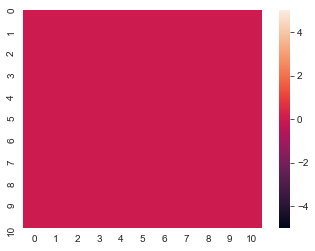

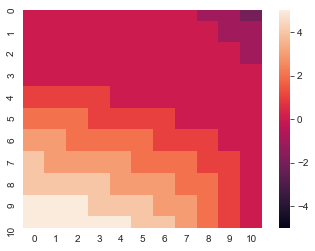

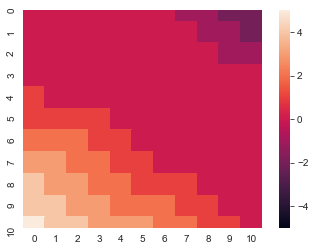

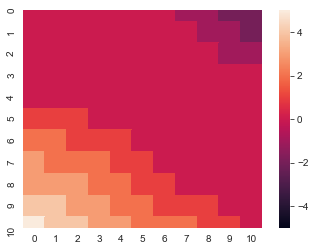

In [9]:
prob_1, R_1 = comp_prob_R(n_car_dim, lam_1_r, lam_1_h)
prob_2, R_2 = comp_prob_R(n_car_dim, lam_2_r, lam_2_h)

changed = True
while True:
    policy_eval()
    changed = policy_imp()
    if changed == False:
        break